# Tully-Fisher Secondary Target Sample: Successful observations

Access secondary PV survey targets intended for TF measurements.

What is the success rate?

In [1]:
import os

from astropy.io import fits
from astropy.table import join, Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.visualization.wcsaxes import SphericalCircle

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/')
from plot_funcs import plot_radec_DESI, get_cutout

import psycopg2

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Postgres Query

See if we have a cached copy of the query results (in FITS format) before running this query.

For connecting to the database, it is recommended that you store the password and connection port in a secure `.pgpass` file on the system or create a private INI file that is not committed to GitHub.  Connection details are not going to be saved in this notebook.  Ask on the `#timedomain-general` or `#peculiar-velocity` or `#transients-lowzcosmo-general` slack channels for more information.

See the [database wiki page](https://desi.lbl.gov/trac/wiki/DESIDatabase) for information about the location and names of tables and their schema.

In [6]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('cache/tf_targets_everest.fits') and use_cached:
    tf_targets = Table.read('cache/tf_targets_everest.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()
        
        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.fiber_ra, fd.fiber_dec, fd.fiberstatus, fd.tileid, zd.target_ra, zd.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn
                   FROM everest.ztile_cumulative_fibermap fd
                   INNER JOIN
                       everest.ztile_cumulative_redshifts zd ON zd.targetid = fd.targetid
                   INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(zd.target_ra*10000 AS INTEGER)) AND 
                                                 (CAST(pr.dec*10000 AS INTEGER) = CAST(zd.target_dec*10000 AS INTEGER))
                   WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA');"""
        
        cursor.execute(query)
        rows = cursor.fetchall()
        tf_targets = Table(list(map(list, zip(*rows))), 
                           names=['PVTYPE', 'SGA_ID', 'TARGETID', 'FIBER_RA', 'FIBER_DEC', 'FIBERSTATUS', 'TILEID', 
                                  'TARGET_RA', 'TARGET_DEC', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
        tf_targets.write('cache/tf_targets_everest.fits', overwrite=True)
        
    except (Exception, psycopg2.errors) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
tf_targets

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64
EXT,17643,39633062056692288,0.0,0.0,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163671928495,39.2330481232594,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163676763292,39.2330716810911,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687172584,39.2330595735952,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687272099,39.2330517354585,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687614895,39.2330239448729,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163692746003,39.2330238257014,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702566258,39.2330592761066,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702811737,39.2330394673576,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0


In [8]:
sv3 = tf_targets['TILEID'] <= 600

print(np.sum(sv3))

sv3_tf_targets = tf_targets[sv3]

24063


## Plot target coordinates

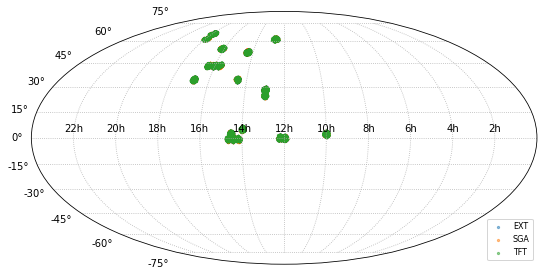

In [9]:
fig = plot_radec_DESI(sv3_tf_targets)

## Plot target redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [10]:
sv3_tf_fibers_targets = sv3_tf_targets[sv3_tf_targets['FIBERSTATUS'] == 0]

isgoodz = (sv3_tf_fibers_targets['DELTACHI2'] >= 25) & (sv3_tf_fibers_targets['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0

tf_good_targets = sv3_tf_fibers_targets[isgoodz]
np.sum(isgoodz)

12321

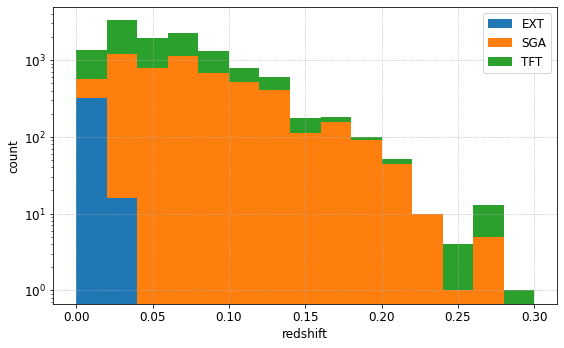

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []

pvtypes = np.unique(tf_good_targets['PVTYPE'])

for pvtype in pvtypes:
    
    ispvtype = tf_good_targets['PVTYPE'] == pvtype
    
    zdata.append(list(tf_good_targets['Z'][ispvtype]))
    
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)

ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Count SGA galaxies with more than one observation

In [11]:
ids_all, counts_all = np.unique(tf_targets['SGA_ID'], return_counts=True)

ids, counts = np.unique(tf_good_targets['SGA_ID'], return_counts=True)
ids[counts > 1]

123
848
896
1548
1583
1980
2497
2950
3164
3727
5732


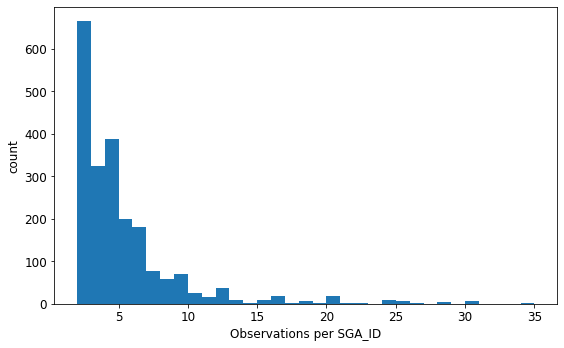

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(counts[counts > 1], bins=np.linspace(2,35,34))

ax.set(xlabel='Observations per SGA_ID', 
       ylabel='count');

In [12]:
# Keep only those with more than one good observation
high_count_all = np.in1d(tf_targets['SGA_ID'], ids_all[counts_all > 1])
sv3_tf_multiple = tf_targets[high_count_all]

high_count_sga = np.in1d(tf_good_targets['SGA_ID'], ids[counts > 1])
tf_multiple = tf_good_targets[high_count_sga]
tf_multiple

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64
EXT,136307,1083296704364547,219.480535322979,-0.400992061081648,0,469,219.480514793136,-0.401016533657631,0.00602564015800929,2.41157274248199e-05,GALAXY,461.575757310098,0
EXT,136307,1083296704364547,219.480535322979,-0.400992061081648,0,469,219.480514793136,-0.401016533657631,0.00615244837181903,4.95611190328384e-05,GALAXY,96.6036016917406,0
EXT,136307,1083296704364547,219.480559889874,-0.401012456648605,0,251,219.480514793136,-0.401016533657631,0.00602564015800929,2.41157274248199e-05,GALAXY,461.575757310098,0
EXT,136307,1083296704364547,219.480559889874,-0.401012456648605,0,251,219.480514793136,-0.401016533657631,0.00615244837181903,4.95611190328384e-05,GALAXY,96.6036016917406,0
EXT,166290,39627770296276005,219.956978762686,-0.718664981531343,0,258,219.956999318774,-0.718640392418429,0.00585565763066172,3.06114101535469e-06,GALAXY,5039.87050774705,0
EXT,166290,39627770296276005,219.956978762686,-0.718664981531343,0,258,219.956999318774,-0.718640392418429,0.00585705053718563,4.04362577202771e-06,GALAXY,3121.93138290849,0
EXT,188925,1070786097971202,193.658786680663,28.9301949759371,0,128,193.658794985168,28.9301636891443,0.00777015714518504,1.28926999325833e-05,GALAXY,95.4629959425074,0
EXT,188925,1083980237504514,193.658786221527,28.9301673252834,0,119,193.658794985168,28.9301636891443,0.00776519502981888,8.32506547625627e-06,GALAXY,629.938170446549,0
EXT,188925,1083980237504515,193.680098739232,28.9466762061603,0,114,193.680147147046,28.9466458254239,0.00891610010101787,6.86421809966094e-06,GALAXY,802.309470949695,0


## Read in SGA catalog

In [13]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Join PV targets with SGA catalog

Loop through the TF target list, apply basic quality cuts to grab TF observations, and join the resulting table with the SGA catalog.

In [14]:
# This cell is for all the observations regardless of redshift quality
sv3_tf_multiple.sort('SGA_ID')

sv3_tf_multiple['r_R26'] = 0.

for sga_id in np.unique(sv3_tf_multiple['SGA_ID']):
    
    targets = sv3_tf_multiple['SGA_ID'] == sga_id
    
    ############################################################################
    # Calculate distance between observation and galaxy center, normalized by 
    # R26
    #---------------------------------------------------------------------------
    # Locate galaxy's center coordinates in the SGA
    center = SkyCoord(SGA['RA'][SGA['SGA_ID'] == sga_id], 
                      SGA['DEC'][SGA['SGA_ID'] == sga_id], 
                      unit='deg')
    
    # Observation coordinates
    tf_obs = SkyCoord(sv3_tf_multiple['FIBER_RA'][targets], 
                      sv3_tf_multiple['FIBER_DEC'][targets], 
                      unit='deg')
    
    # Calculate sky separation
    sep2d = tf_obs.separation(center)
    
    # R26
    R26 = 0.5*SGA['D26'][SGA['SGA_ID'] == sga_id]
    
    # Normalize by R26
    sv3_tf_multiple['r_R26'][targets] = sep2d.to('arcmin')/(R26*u.arcmin)
    ############################################################################

In [14]:
tf_multiple.sort('SGA_ID')

keepsga = []

for sga_id in np.unique(tf_multiple['SGA_ID']):
    target_list = tf_multiple[tf_multiple['SGA_ID'] == sga_id]
    
    # Total hack to find SGA target, because the PVTYPE cannot be trusted
    # Talk to an expert about actual SGA targets in DESI
    is_sga_center = (target_list['TARGETID'] > 30000000000000000) & (target_list['TARGETID'] < 40000000000000000)
    
    sga_center = target_list[is_sga_center]
    tf_list = target_list[~is_sga_center]
    
    if len(tf_list) == 0:
        #print('Ony center observations of galaxy {}'.format(sga_id))
        continue
    
    ############################################################################
    # Calculate distance from center for each target
    #---------------------------------------------------------------------------
    # D26 in arcmin
    d26 = float(SGA['D26'][SGA['SGA_ID'] == sga_id])*u.arcmin
    
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    
    if np.sum(is_sga_center) < 1:
        # This is OK, so long as we have an observation at 0.3R or 0.4R on both sides
        
        center = SkyCoord(SGA['RA'][SGA['SGA_ID'] == sga_id], 
                          SGA['DEC'][SGA['SGA_ID'] == sga_id], 
                          unit='deg')
        
        sep2d = offcenter.separation(center)
        
        # How many are at either 0.3R or 0.4R?
        dist_from_center = sep2d.to('arcmin')/(0.5*d26)
        
        if np.sum((dist_from_center > 0.25) & (dist_from_center < 0.45)) > 2:
            
            # Do they sit on either side of the galaxy?
            p3R26 = tf_list[(dist_from_center > 0.25) & (dist_from_center < 0.45)]
            
            delta_ra = SGA['RA'][SGA['SGA_ID'] == sga_id] - p3R26['FIBER_RA']
            delta_dec = SGA['DEC'][SGA['SGA_ID'] == sga_id] - p3R26['FIBER_DEC']
            
            if (0 < np.sum(delta_ra < 0) < len(p3R26)) or (0 < np.sum(delta_dec < 0) < len(p3R26)):
                keepsga.append(sga_id)
                '''
                # Pad the image cutout of the galaxy.
                npix = np.minimum(int(1.025 * d26.to('arcsec').value/0.262), 512)

                img_file, wcs = get_cutout(sga_id, 
                                           SGA['RA'][SGA['SGA_ID'] == sga_id][0], 
                                           SGA['DEC'][SGA['SGA_ID'] == sga_id][0], 
                                           size=npix, 
                                           verbose=True)
                img = mpl.image.imread(img_file)

                fig = plt.figure(figsize=(7,5))

                ax = fig.add_subplot(111, projection=wcs)
                ax.imshow(np.flip(img, axis=0))
                ax.set(xlabel='ra', ylabel='dec')
                ax.text(int(0.02*npix), 
                        int(0.85*npix), 
                        'SGA_ID: {}$'.format(sga_id), 
                        fontsize=9, 
                        color='yellow')
                overlay = ax.get_coords_overlay('icrs')
                overlay.grid(color='white', ls='dotted');

                # Add the location of the SDSS and DESI fibers.
                # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
                r1 = SphericalCircle((SGA['RA'][SGA['SGA_ID'] == sga_id][0]*u.deg, 
                                      SGA['DEC'][SGA['SGA_ID'] == sga_id][0]*u.deg), 
                                     2*u.arcsec,
                                     edgecolor='black', 
                                     facecolor='none', 
                                     alpha=0.8, 
                                     lw=3,
                                     transform=ax.get_transform('icrs'))
                r2 = SphericalCircle((SGA['RA'][SGA['SGA_ID'] == sga_id][0]*u.deg, 
                                      SGA['DEC'][SGA['SGA_ID'] == sga_id][0]*u.deg), 
                                     2*u.arcsec,
                                     edgecolor='red', 
                                     facecolor='none', 
                                     alpha=0.8, 
                                     lw=2,
                                     transform=ax.get_transform('icrs'))
                ax.add_patch(r1)
                ax.add_patch(r2)

                for tft in tf_list:
                    ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])

                    # Add the location of the SDSS and DESI fibers.
                    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
                    r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                                         edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                                         transform=ax.get_transform('icrs'))
                    r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                                         edgecolor='lime', facecolor='none', alpha=0.8, lw=2,
                                         transform=ax.get_transform('icrs'))
                    ax.add_patch(r1)
                    ax.add_patch(r2)

                fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
                ''';
    else:
        
        center = SkyCoord(sga_center['FIBER_RA'][0], 
                          sga_center['FIBER_DEC'][0], 
                          unit='deg')
        
        sep2d = offcenter.separation(center)
        #print(sep2d.to('arcmin')/(0.5*d26))
        
        dist_from_center = sep2d.to('arcmin')/(0.5*d26)
        
        if any((dist_from_center > 0.25) & (dist_from_center < 0.45)):
            keepsga.append(sga_id)
    ############################################################################

len(keepsga)

1180

In [19]:
sv3_tf_multiple.write('SV3_PV_everest.fits', format='fits')

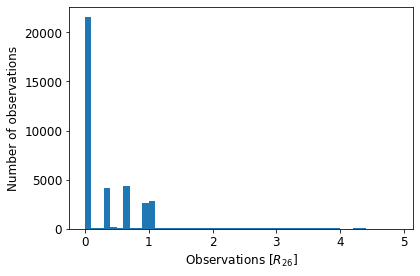

In [18]:
plt.figure(tight_layout=True)

plt.hist(sv3_tf_multiple['r_R26'], bins=np.arange(0,5,0.1))

plt.xlabel('Observations [$R_{26}$]')
plt.ylabel('Number of observations');